### Import libraries and data

In [1]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import datetime
from datetime import date
import random


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Data
data = pd.read_csv('./data/Metro_Interstate_Traffic_Volume.csv', infer_datetime_format=True)

In [3]:
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data['date_time'] =  pd.to_datetime(data['date_time'], format='%Y-%m-%d %H')

In [5]:
data = data.set_index(pd.DatetimeIndex(data['date_time'])).rename(columns={"date_time": "ds"}).drop_duplicates(subset=['ds'])

In [6]:
ts = data['2018-06-30':'2018-09-29']
ts.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,ds,traffic_volume
date_time,,,,,,,,,
2018-06-30 00:00:00,None,302.87,0.0,0.0,1,Clear,sky is clear,2018-06-30 00:00:00,1423
2018-06-30 01:00:00,None,302.58,0.0,0.0,1,Clear,sky is clear,2018-06-30 01:00:00,869
2018-06-30 02:00:00,None,302.55,0.0,0.0,1,Thunderstorm,proximity thunderstorm,2018-06-30 02:00:00,617
2018-06-30 03:00:00,None,302.29,0.0,0.0,40,Rain,moderate rain,2018-06-30 03:00:00,429
2018-06-30 04:00:00,None,301.29,0.0,0.0,1,Rain,light rain,2018-06-30 04:00:00,429


Train/Test Split

In [7]:
split_date = '2018-09-22'
ts_train = ts.loc[ts.index <= split_date].copy()
ts_test = ts.loc[ts.index > split_date].copy()

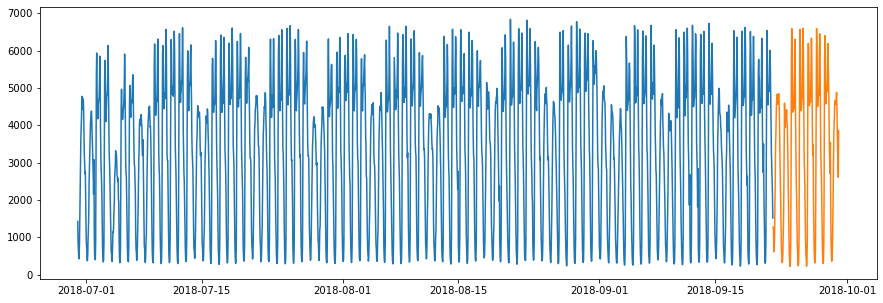

In [8]:
plt.figure(figsize=(15,5))
plt.plot(ts_train.traffic_volume)
plt.plot(ts_test.traffic_volume)
plt.show()

### Create Time Series Features

In [9]:
def create_features(df, label=None, all_features=False):
    """
    Creates time series features from datetime
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    if all_features:
        X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear',
                'holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description']]
    else :
        X = df[['hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
X_train, y_train = create_features(ts_train, label='traffic_volume', all_features=False)
X_test, y_test = create_features(ts_test, label='traffic_volume', all_features=False)

### Create XGboost model with only time features

In [11]:
%%time
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

Wall time: 1.81 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

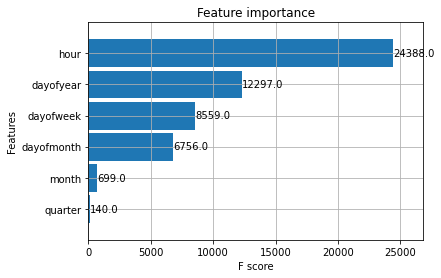

In [12]:
plot_importance(reg, height=0.9)

##### Predict on test data

In [13]:
%%time
y_pred = reg.predict(X_test)

Wall time: 9 ms


##### Error Metrics

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
def error_metrics(y_true, y_pred):
    print('Mean Absolute Error: {:.2f}'.format(mean_absolute_error(y_true, y_pred)))
    print('Root Mean Squared Error: {:.2f}'.format(np.sqrt(mean_squared_error(y_true, y_pred))))
    print('Mean Absolute percentage Error: {:.2f} %'.format(mean_absolute_percentage_error(y_true, y_pred)))

In [16]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 213.37
Root Mean Squared Error: 311.21
Mean Absolute percentage Error: 12.48 %


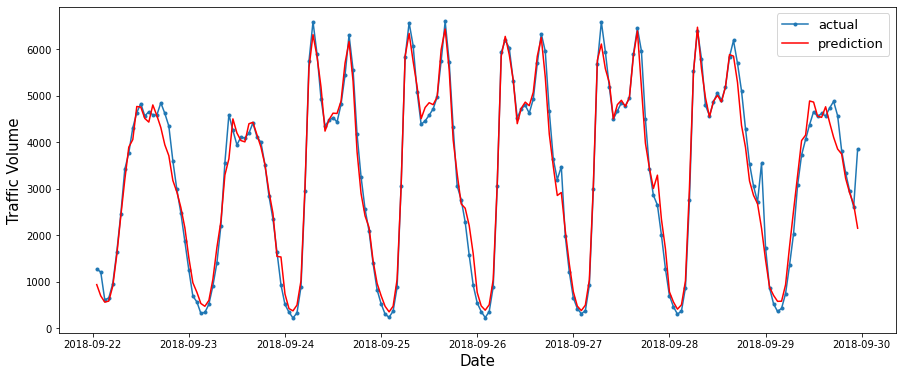

In [17]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

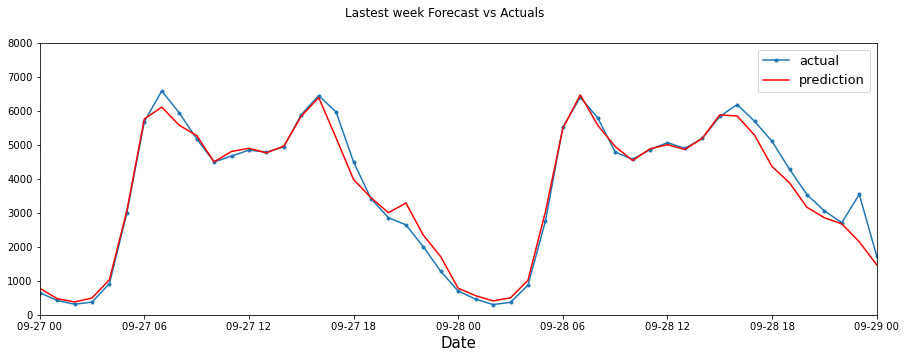

In [18]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest week Forecast vs Actuals')

### Create XGboost model with all features

In [19]:
X_train, y_train = create_features(ts_train, label='traffic_volume', all_features=True)
X_test, y_test = create_features(ts_test, label='traffic_volume', all_features=True)

In [20]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [21]:
# Feature engineering
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, make_column_selector(dtype_include="object")),
        ("num", numeric_transformer, make_column_selector(dtype_exclude="object")),
    ]
)

In [22]:
my_pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

In [23]:
# Transform the data
X_train = my_pipeline.fit_transform(X_train)
X_test = my_pipeline.transform(X_test)

In [24]:
%%time
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

Wall time: 3.02 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

##### Predict on test data

In [25]:
%%time
y_pred = reg.predict(X_test)

Wall time: 6.99 ms


##### Error Metrics

In [26]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 181.95
Root Mean Squared Error: 281.19
Mean Absolute percentage Error: 9.68 %


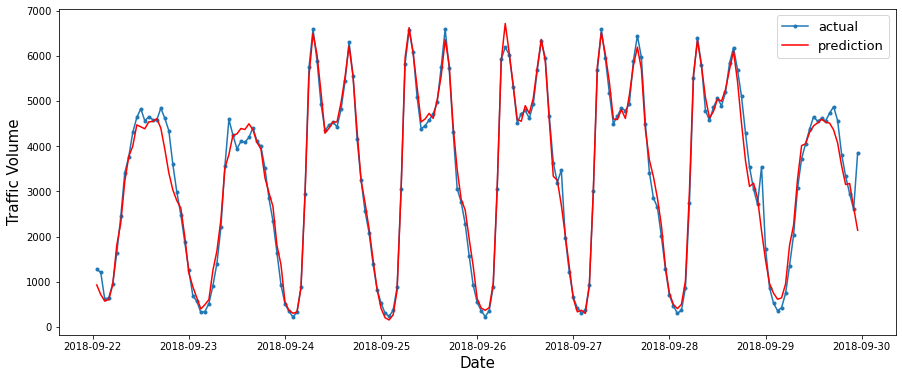

In [27]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

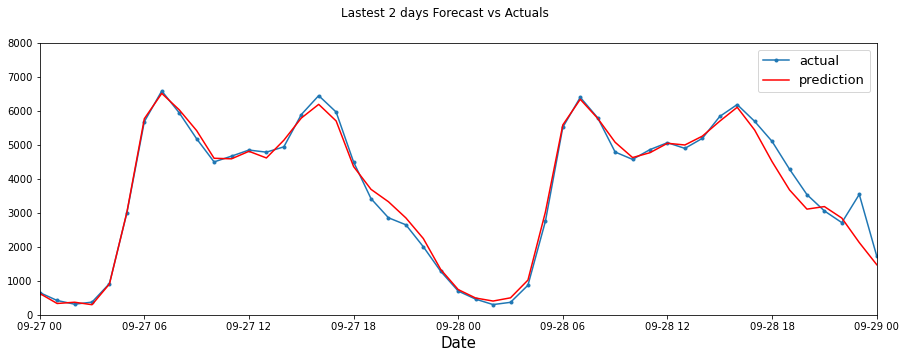

In [28]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')

### HyperParmeter Tuning

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [30]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [31]:
# Initialize space or a required range of values
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.uniform('reg_alpha', 0,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'subsample' : hp.quniform('subsample', 0.6, 1, 0.05),
        'n_estimators': hp.uniform('n_estimators', 500, 1000)
    }

In [32]:
# Define objective function
def hyperparameter_tuning(space):
    model=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                           reg_alpha = int(space['reg_alpha']) ,reg_lambda=space['reg_lambda'], 
                            colsample_bytree=space['colsample_bytree'], min_child_weight=space['min_child_weight']
                           ,subsample=space['subsample'])
    kfold = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = cross_val_score(model, X_train, y_train, cv=kfold, scoring = 'neg_mean_absolute_percentage_error')
    score = results.mean() * (-100)
    print ("SCORE:", score)
    return {'loss':score, 'status': STATUS_OK, 'model': model}

In [33]:
trials = Trials()

In [34]:
%%time
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

SCORE:                                                 
8.432802110522367                                      
SCORE:                                                                          
11.62918763295493                                                               
SCORE:                                                                            
7.772737097873613                                                                 
SCORE:                                                                            
9.892930993750296                                                                 
SCORE:                                                                            
8.11003632287907                                                                  
SCORE:                                                                            
10.152465305251926                                                                
SCORE:                                                        

SCORE:                                                                             
9.395572151088798                                                                  
SCORE:                                                                             
9.813070043582306                                                                  
SCORE:                                                                             
12.201277735845723                                                                 
SCORE:                                                                             
7.493575037659269                                                                  
SCORE:                                                                             
7.63554344945737                                                                   
SCORE:                                                                             
7.857649109308388                                                           

15.387009206510765                                                               
SCORE:                                                                             
7.45247106636508                                                                   
SCORE:                                                                             
7.112712346983217                                                                  
SCORE:                                                                              
7.295182864409186                                                                   
SCORE:                                                                              
13.113499987350124                                                                
SCORE:                                                                            
7.95573600596068                                                                  
SCORE:                                                                        

6.594163474270069                                                                 
SCORE:                                                                            
6.459992221705321                                                                 
SCORE:                                                                            
6.916974882878351                                                                 
SCORE:                                                                            
6.286005244031487                                                                 
SCORE:                                                                              
7.498307876129681                                                                   
SCORE:                                                                              
6.442866596052915                                                                   
SCORE:                                                                         

6.527938444569569                                                                   
SCORE:                                                                              
7.489579658102713                                                                   
SCORE:                                                                              
8.766069088884185                                                                   
SCORE:                                                                              
6.33166864211787                                                                    
SCORE:                                                                              
6.969781188945144                                                                   
SCORE:                                                                              
7.8922771458855125                                                                  
SCORE:                                                           

7.686440820167564                                                                   
SCORE:                                                                              
14.220183688190394                                                                  
SCORE:                                                                              
8.36200986266118                                                                    
SCORE:                                                                              
7.195871062165923                                                                   
SCORE:                                                                              
7.31281846423735                                                                    
SCORE:                                                                              
6.340709107983197                                                                   
SCORE:                                                           

8.011335949930178                                                                   
SCORE:                                                                              
7.773837062477093                                                                   
SCORE:                                                                              
7.273536397410312                                                                   
SCORE:                                                                              
6.546741132137976                                                                   
SCORE:                                                                              
7.6671622224854                                                                     
SCORE:                                                                              
8.14281005030774                                                                    
SCORE:                                                           

In [35]:
print (best)

{'colsample_bytree': 0.9685367014079093, 'gamma': 4.484060055612197, 'max_depth': 16.0, 'min_child_weight': 2.0, 'n_estimators': 741.3927491348486, 'reg_alpha': 0.4506812188655929, 'reg_lambda': 0.903238384675147, 'subsample': 1.0}


In [36]:
best['max_depth'] = int(best['max_depth'])
best['n_estimators'] = int(best['n_estimators'])

In [37]:
reg_opt = xgb.XGBRegressor(**best)

In [38]:
%%time
reg_opt.fit(X_train, y_train)

Wall time: 5.64 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9685367014079093,
             enable_categorical=False, gamma=4.484060055612197, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=16,
             min_child_weight=2.0, missing=nan, monotone_constraints='()',
             n_estimators=741, n_jobs=8, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.4506812188655929,
             reg_lambda=0.903238384675147, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

##### Predict on test data

In [39]:
%%time
y_pred = reg_opt.predict(X_test)

Wall time: 5 ms


##### Error Metrics

In [40]:
#Calculate Model error
error_metrics(ts_test.traffic_volume, y_pred)

Mean Absolute Error: 181.79
Root Mean Squared Error: 277.48
Mean Absolute percentage Error: 8.00 %


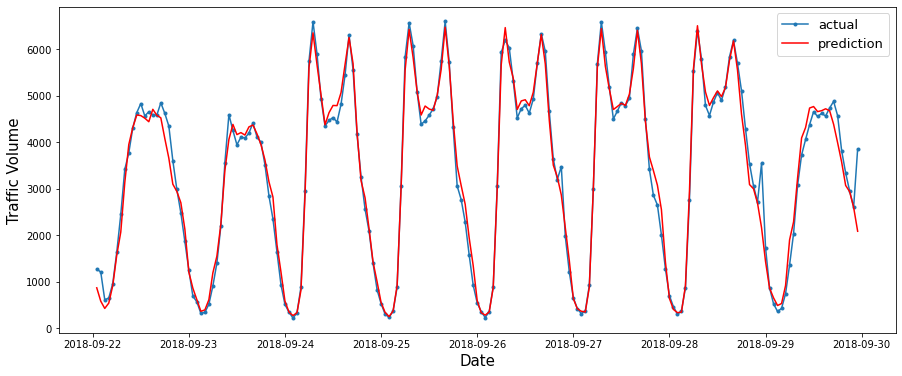

In [41]:
plt.figure(figsize=(15,6))
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
plt.ylabel('Traffic Volume', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=13)
plt.show()

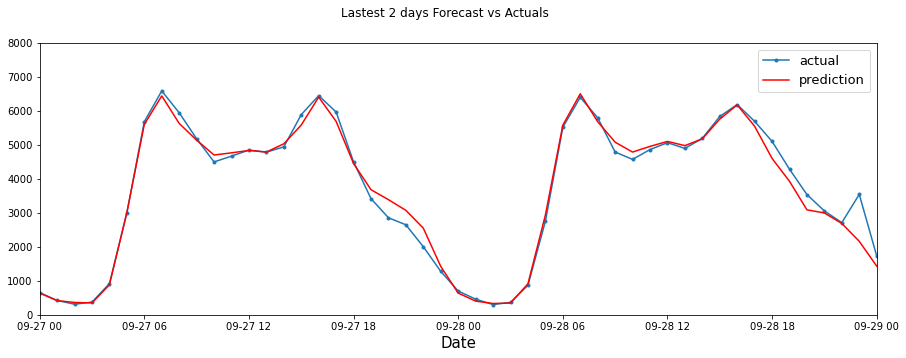

In [42]:
# zoom on lastest 2 days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, pd.DataFrame(ts_test.traffic_volume), marker='.', label="actual")
plt.plot(ts_test.index, y_pred, 'r', label="prediction")
ax.set_xbound(lower= datetime.date(2018,9,27), upper=datetime.date(2018,9,29))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
ax.set_ylim(0, 8000)
plot = plt.suptitle('Lastest 2 days Forecast vs Actuals')